<a href="https://colab.research.google.com/github/Zalake/ML-Project-GAN-and-VAE-/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
#import everything possible############
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
mnist=tf.keras.datasets.mnist

In [100]:
latentDimension = 2
######define encoder model##########################
inputs = tf.keras.Input(shape=(784,))
h1=tf.keras.layers.Dense(784,activation='relu')(inputs)
h2 = tf.keras.layers.Dense(128, activation='relu')(h1)
h3 = tf.keras.layers.Dense(64, activation='relu')(h2)
meanZ = tf.keras.layers.Dense(latentDimension)(h3)
varZ = tf.keras.layers.Dense(latentDimension)(h3)


In [109]:
from keras import backend as K

def sampling(args):
    meanZ, varZ = args
    epsilon = K.random_normal(shape=(K.shape(meanZ)[0], latentDimension),
                              mean=0., stddev=0.1)
    return meanZ + K.exp(varZ) * epsilon

z = tf.keras.layers.Lambda(sampling)([meanZ, varZ])

In [110]:
encoder = tf.keras.Model(inputs, [meanZ, varZ, z], name='encoder')
encoder.summary()
# Create decoder
latent_inputs = tf.keras.Input(shape=(latentDimension,), name='z_sampling')
x1 = tf.keras.layers.Dense(64, activation='relu')(latent_inputs)
x2 = tf.keras.layers.Dense(128, activation='relu')(x1)
outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x2)
# optputs=tf.keras.layers.Reshape(28,28)(outputs)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='VAE')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_123 (Dense)               (None, 784)          615440      input_15[0][0]                   
__________________________________________________________________________________________________
dense_124 (Dense)               (None, 128)          100480      dense_123[0][0]                  
__________________________________________________________________________________________________
dense_125 (Dense)               (None, 64)           8256        dense_124[0][0]                  
____________________________________________________________________________________________

In [111]:
lReconstruction = tf.keras.losses.binary_crossentropy(inputs, outputs)
lReconstruction = lReconstruction*784
klDivergence = 1 + varZ - K.square(meanZ) - K.exp(varZ)
klDivergence = K.sum(klDivergence, axis=-1)
klDivergence *= -0.5
vae_loss = K.mean(lReconstruction + klDivergence)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [112]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
print(x_train.shape)
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

(60000, 28, 28)
Epoch 1/100
 719/1875 [==========>...................] - ETA: 3s - loss: 189.7038

KeyboardInterrupt: ignored

[-2.         -1.86206897 -1.72413793 -1.5862069  -1.44827586 -1.31034483
 -1.17241379 -1.03448276 -0.89655172 -0.75862069 -0.62068966 -0.48275862
 -0.34482759 -0.20689655 -0.06896552  0.06896552  0.20689655  0.34482759
  0.48275862  0.62068966  0.75862069  0.89655172  1.03448276  1.17241379
  1.31034483  1.44827586  1.5862069   1.72413793  1.86206897  2.        ]


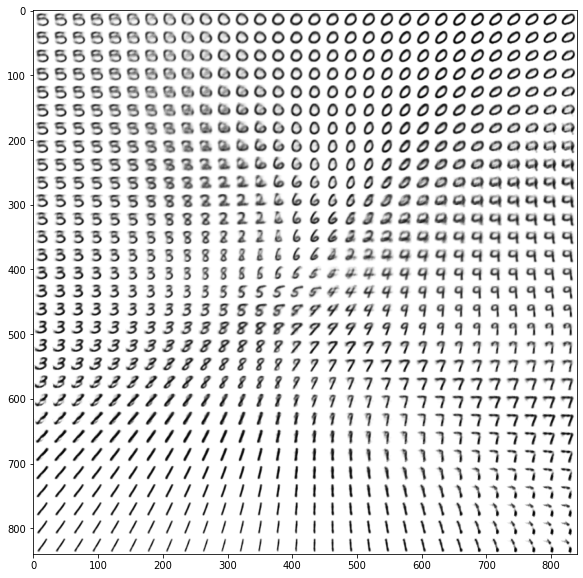

In [67]:
##############generate 900 images using latents points that are linearly spaced with spacing =2#################################
n = 30
digit_size = 28
scale = 2.0
figsize = 15
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]
######create an array to store the generated images, this will be required to evaluate the performance against GAN#########
generatedImagesArray=[]
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        generatedImagesArray.append(digit)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray_r')
plt.show()

In [113]:
######################################next to baseline, 2nd model with conv layers
latentDimension = 2

inputs = tf.keras.Input(shape=(784,))
h1=tf.keras.layers.Dense(784)(inputs)
#reshape input 784 pixels to create an image###
h2=tf.keras.layers.Reshape((28,28,1))(h1)
###aply conv and downsample the image slowly
h3=tf.keras.layers.Conv2D(64,(3,3),strides=(2,2),padding='same',activation=tf.nn.relu)(h2)
h4=tf.keras.layers.Conv2D(64,(3,3),strides=(2,2),padding='same',activation=tf.nn.relu)(h3)
h5=tf.keras.layers.Flatten()(h4)
h6 = tf.keras.layers.Dense(16, activation='relu')(h5)
meanZ = tf.keras.layers.Dense(latentDimension)(h6)
varZ = tf.keras.layers.Dense(latentDimension)(h6)

# encoderModel=Model(inputs,h4)
# encoderModel.summary()







In [120]:
from keras import backend as K

def sampling(args):
    meanZ, varZ = args
    epsilon = K.random_normal(shape=(K.shape(meanZ)[0], latentDimension),
                              mean=0., stddev=0.1)
    return meanZ + K.exp(varZ) * epsilon

z = tf.keras.layers.Lambda(sampling)([meanZ, varZ])

encoder = tf.keras.Model(inputs, [meanZ, varZ, z], name='encoder')

In [121]:
encoder = tf.keras.Model(inputs, [meanZ, varZ, z], name='encoder')
encoder.summary()
# Create decoder
latent_inputs = tf.keras.Input(shape=(latentDimension,), name='z_sampling')
x = tf.keras.layers.Dense(32*7*7, activation='relu')(latent_inputs)
dh1=tf.keras.layers.Reshape((7,7,32))(x)
dh2=tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same',activation=tf.nn.relu)(dh1)
dh3=tf.keras.layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding='same',activation=tf.nn.relu)(dh2)
dh4=tf.keras.layers.Conv2D(1,(3,3),strides=(1,1),padding='same',activation='sigmoid')(dh3)
outputs = tf.keras.layers.Flatten()(dh4)

# optputs=tf.keras.layers.Reshape(28,28)(outputs)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='VAE')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_137 (Dense)               (None, 784)          615440      input_16[0][0]                   
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense_137[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   640         reshape[0][0]                    
____________________________________________________________________________________________

In [122]:
lReconstruction = tf.keras.losses.binary_crossentropy(inputs, outputs)
lReconstruction = lReconstruction*28*28
klDivergence = 1 + varZ - K.square(meanZ) - K.exp(varZ)
klDivergence = K.sum(klDivergence, axis=-1)
klDivergence *= -0.5
vae_loss = K.mean(lReconstruction + klDivergence)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [123]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
print(x_train.shape)
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))

vae.fit(x_train, x_train,
        epochs=200,
        batch_size=16,
        validation_data=(x_test, x_test))

(60000, 28, 28)
Epoch 1/200
 765/3750 [=====>........................] - ETA: 13s - loss: 187.9301

KeyboardInterrupt: ignored

[-2.         -1.86206897 -1.72413793 -1.5862069  -1.44827586 -1.31034483
 -1.17241379 -1.03448276 -0.89655172 -0.75862069 -0.62068966 -0.48275862
 -0.34482759 -0.20689655 -0.06896552  0.06896552  0.20689655  0.34482759
  0.48275862  0.62068966  0.75862069  0.89655172  1.03448276  1.17241379
  1.31034483  1.44827586  1.5862069   1.72413793  1.86206897  2.        ]


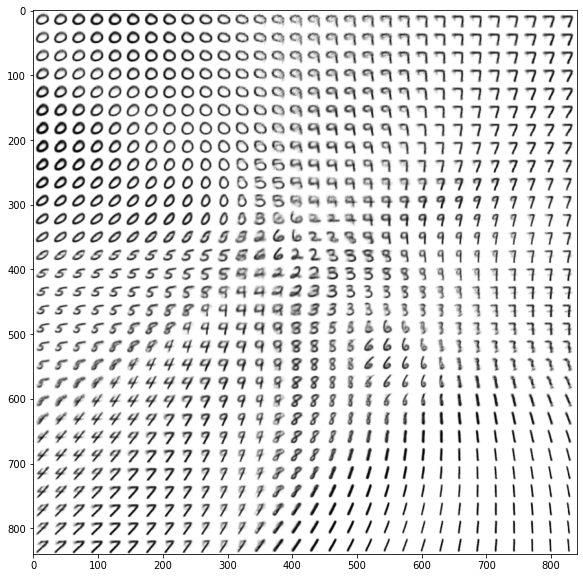

In [126]:

#####load the saved model to generate 900 images using latent points that are linearly spaced#################
decoder=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/MLModelsVAE/VAEDecoderModel2020-12-12 22:39:51.343867.h5')
n = 30
digit_size = 28
scale = 2.0
figsize = 15
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]
#store images into array so that it can be used to compare against GAN
generatedImagesArray=[]
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        generatedImagesArray.append(digit)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray_r')
plt.show()

In [127]:
#####load discriminatior and evaluate the image accuracy with the it############
model_discriminator=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/MLModelsVAE/discModel2020-12-12 21_59_02.611410.h5')
generatedLabels=ones((900,1))
generatedImagesArray=np.array(generatedImagesArray).reshape(900,28,28,1)
score = model_discriminator.evaluate(generatedImagesArray, generatedLabels, verbose=0)
print("Test loss:", score[0])
########## it can be seen that the loss is 4 for VAE, while it was 1.2 for GAN, hence GANs perform better than VAE

Test loss: 4.494743347167969
